In [1]:
from pathlib import Path
from datetime import datetime
from os import PathLike
from typing import Union

# data manipulation and analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
from prettytable import PrettyTable
import plotly.express as px # An interactive graphing library that makes interactive, publication-quality graphs online.
import plotly.graph_objs as go # An interactive graphing library that makes interactive, publication-quality graphs online.

# ML model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# data = pd.read_csv('/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/1-raw/demand')

raw_data_dir = '/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/1-raw/demand'
raw_data_path = Path(raw_data_dir)
compiled_data_dir = '/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/2-compiled/demand'
compiled_data_path = Path(compiled_data_dir)
imputed_data_dir = '/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/3-imputed/demand'
imputed_data_path = Path(imputed_data_dir)

In [3]:
print(raw_data_path)

/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/1-raw/demand


In [4]:
def format_demand_file(filepath: Union[str, PathLike]) -> pd.DataFrame:
    """
    Read an IESO .csv demand file to a Pandas DataFrame
    Accepts pre 2002 format and post 2001 format
    Clean up - shorten col names, merge date and time to datetime, set datetime index
    Returns ascending date sorted DataFrame
    """
    keeper_cols = ['datetime', 'ont_demand']
    if '1994-2002' in str(filepath):
        col_renames = {'DateTime': 'datetime', 'OntarioDemand': 'ont_demand'}
        header = 0
    else:
        col_renames = {'Date': 'date', 'Hour': 'time', 'Ontario Demand': 'ont_demand'}
        header = 3
        
    df = pd.read_csv(filepath, header=header, parse_dates=True, dtype={'Hour': int}, infer_datetime_format=True)
    df.rename(columns=col_renames, inplace=True)

    if 'datetime' not in df.columns:
        df['time'] = df['time'] - 1
        df['datetime'] = pd.to_datetime(df['date']) + df['time'].astype('timedelta64[h]')
    else:
        df['datetime'] = pd.to_datetime(df['datetime'])

    df = df[keeper_cols]
    df.set_index('datetime', inplace=True, drop=True)
    df.sort_index(inplace=True)
    
    return df

In [5]:
# get the raw directory filepaths
csv_fps = [fp for fp in raw_data_path.iterdir() if fp.is_file()]

In [103]:
# create multiple dataframess from each filepath
dfs = [format_demand_file(fp) for fp in csv_fps]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_4518/3037781313.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(filepath, header=header, parse_dates=True, dtype={'Hour': int}, infer_datetime_format=True)
/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_4518/3037781313.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(filepath, header=header, parse_dates=True, dtype={'Hour': int}, infer_datetime_format=True)
/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_4518/3037781313.py:16: Fu

In [104]:
# combine into a single DataFrame and save in the interim dir
df = pd.concat(dfs, axis=0)
df.sort_index(inplace=True)
df.to_csv(compiled_data_path / "demand.csv", index=True)

In [6]:
demand_df = pd.read_csv(compiled_data_path/'demand.csv', index_col='datetime', parse_dates=True)
demand_df.head()

,ont_demand
datetime,
1994-01-01 00:00:00,14422
1994-01-01 01:00:00,13845
1994-01-01 02:00:00,13372
1994-01-01 03:00:00,13025
1994-01-01 04:00:00,12869


In [7]:
demand_df.tail()

,ont_demand
datetime,
2019-06-03 19:00:00,15518
2019-06-03 20:00:00,15513
2019-06-03 21:00:00,14664
2019-06-03 22:00:00,13517
2019-06-03 23:00:00,12464


In [8]:
demand_df.shape

(222096, 1)

In [107]:
print(demand_df.columns)

Index(['ont_demand'], dtype='object')


In [108]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222096 entries, 1994-01-01 00:00:00 to 2019-06-03 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   ont_demand  222096 non-null  int64
dtypes: int64(1)
memory usage: 3.4 MB


## Visualizing data

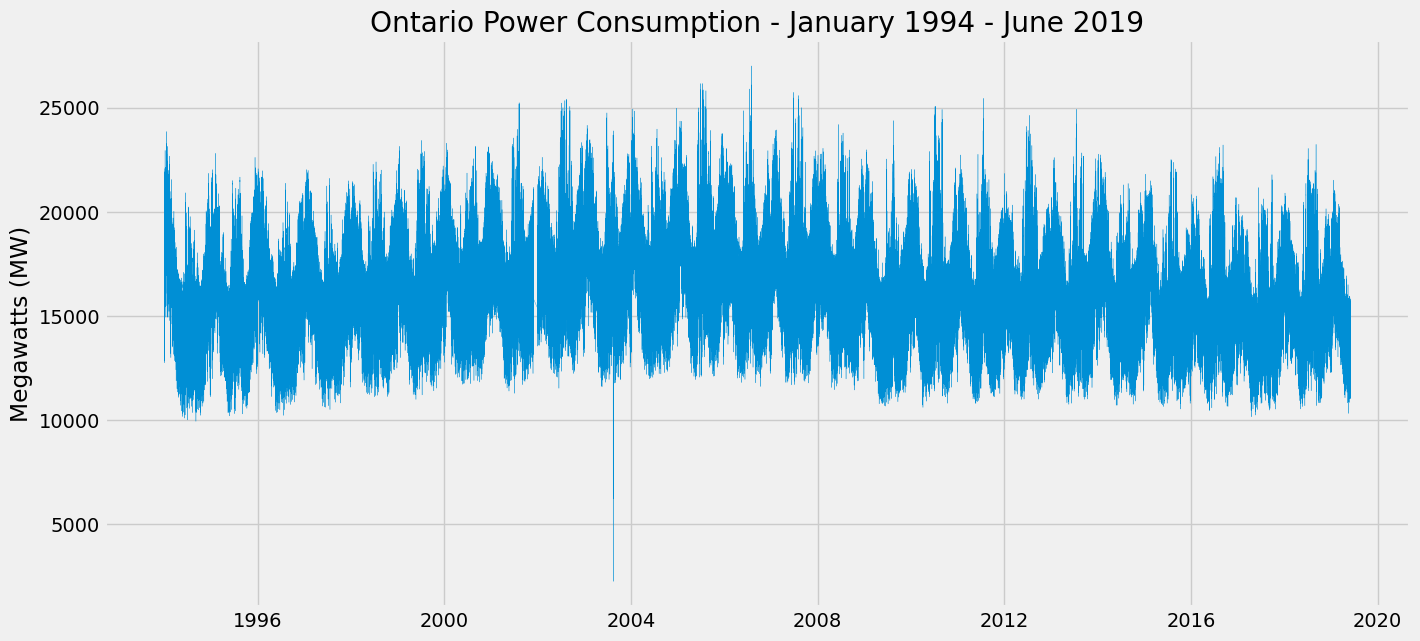

In [109]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(demand_df, linewidth=0.25)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - January 1994 - June 2019')
plt.show();

Closer look at 2001 to 2002 data

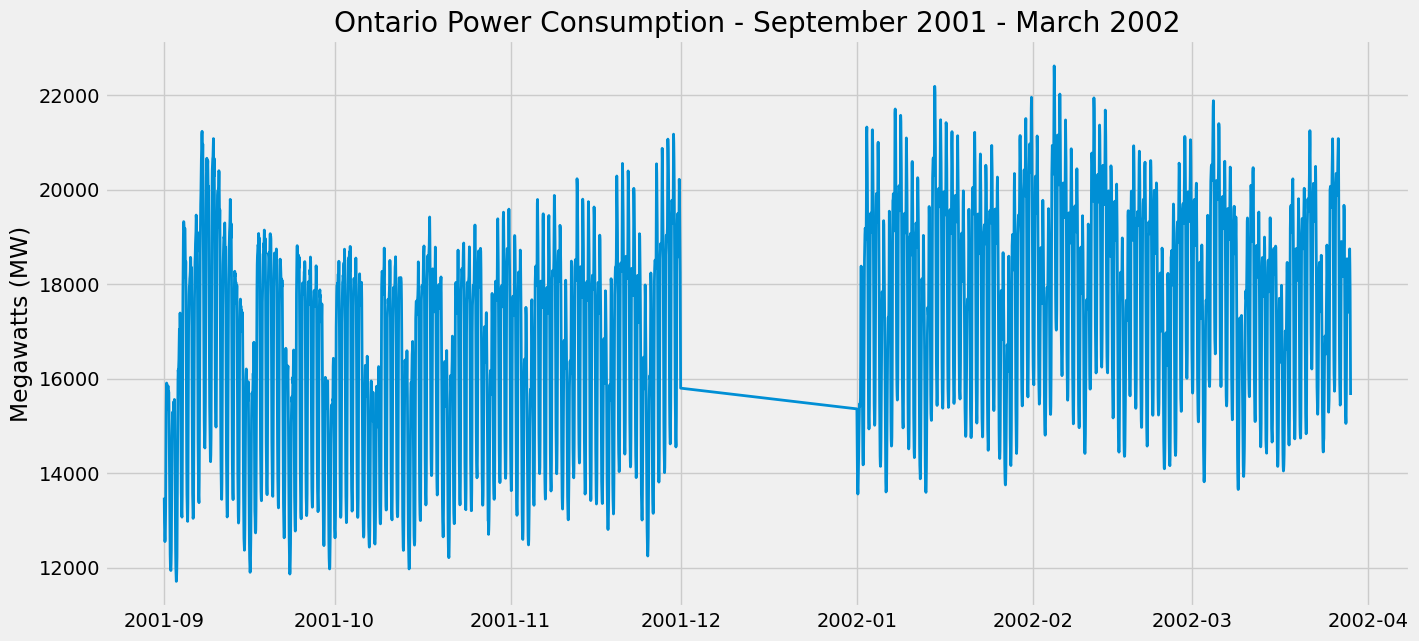

In [110]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(demand_df.loc['2001-09-01':'2002-03-28'], linewidth=2.0)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - September 2001 - March 2002')
plt.show();

Imputation to be done in this gap

Plot the December data for the years either side of the missing data using a common y scale



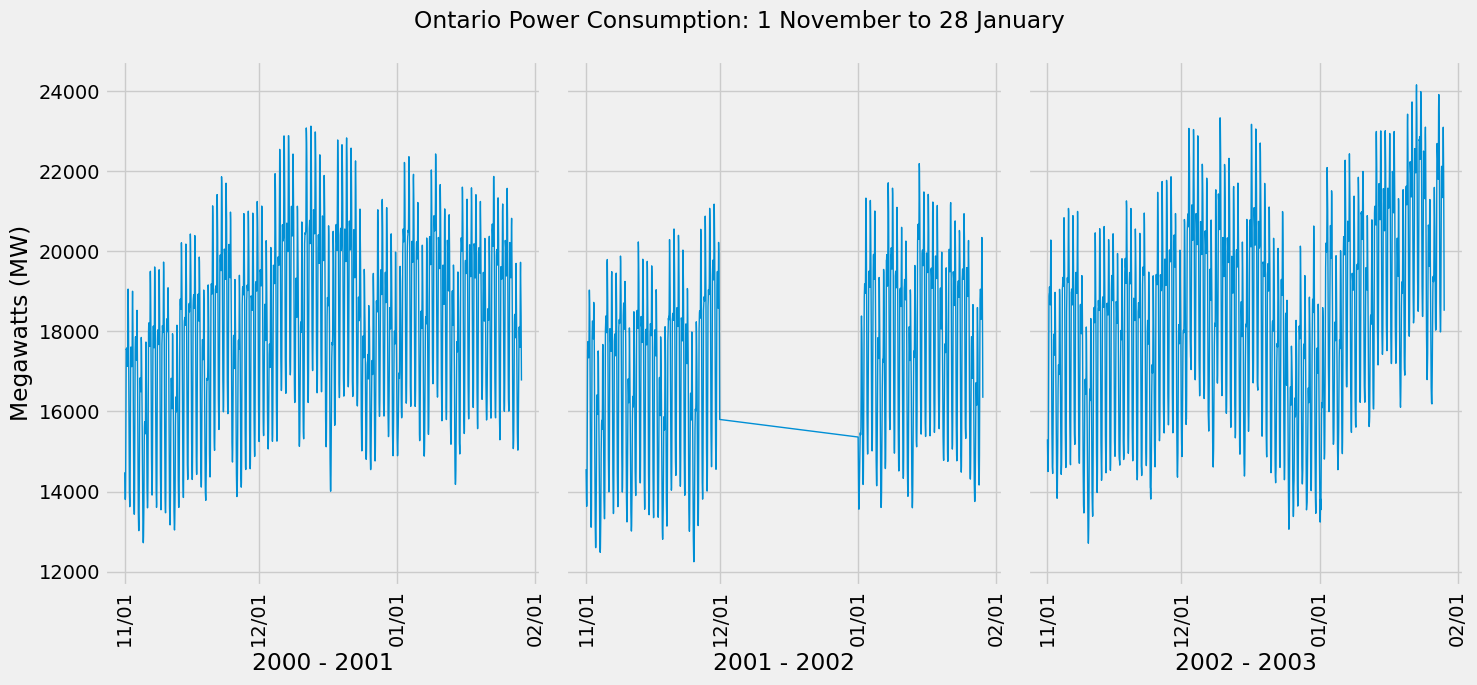

In [111]:
plt.style.use('fivethirtyeight')
myFmt = DateFormatter("%m/%d") 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,7), sharey=True)
ax1.plot(demand_df.loc['2000-11-01':'2001-01-28'], linewidth=1)
ax2.plot(demand_df.loc['2001-11-01':'2002-01-28'], linewidth=1)
ax3.plot(demand_df.loc['2002-11-01':'2003-01-28'], linewidth=1)

ax1.xaxis.set_major_formatter(myFmt) ; ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(myFmt) ; ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(myFmt) ; ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_xlabel('2000 - 2001')
ax2.set_xlabel('2001 - 2002')
ax3.set_xlabel('2002 - 2003')

ax1.set_ylabel('Megawatts (MW)')
plt.suptitle('Ontario Power Consumption: 1 November to 28 January')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

On the basis of a visual comparison, 2000 - 2001 is the closest pattern to 2001 - 2002 demand data. Therefore, the 2000 data is mapped with the days equivalent to the missing portion of 2001

### Imputing the data

In [112]:
# start = '2001-12-01 00:00:00' ; end = '2001-12-31 23:00:00' ; freq = '1h'

# # Get all the inputed values into an array
# imputed_vals = [*list(demand_df.loc['2000-12-02' : '2000-12-24', 'ont_demand'].values),
#                 *demand_df.loc['2000-12-27', 'ont_demand'].values,
                
#                 *demand_df.loc['2000-12-25', 'ont_demand'].values,
#                 *demand_df.loc['2000-12-26', 'ont_demand'].values,
#                 *demand_df.loc['2000-12-28' : '2000-12-31', 'ont_demand'].values,
#                 *demand_df.loc['2000-12-29', 'ont_demand'].values               
#                ]

# demand_df.loc[start : end, 'ont_demand'] = imputed_vals

In [113]:
import pandas as pd

# defining the missing and imputation periods
missing_start = '2001-12-01 00:00:00'
missing_end = '2001-12-31 23:00:00'
impute_start = '2000-12-01 00:00:00'
impute_end = '2000-12-31 23:00:00'

if not isinstance(demand_df.index, pd.DatetimeIndex):
    demand_df.index = pd.to_datetime(demand_df.index)

# datetime index for the entire period of interest
full_period = pd.date_range(start=demand_df.index.min(), end=demand_df.index.max(), freq='1h')

# reindex the DataFrame to ensure it contains all the hours in the period of interest
demand_df = demand_df.reindex(full_period)

print(f"Missing period in DataFrame:\n{demand_df.loc[missing_start:missing_end]}")

imputed_vals = demand_df.loc[impute_start:impute_end, 'ont_demand'].values

missing_period = pd.date_range(start=missing_start, end=missing_end, freq='1h')
if len(missing_period) != len(imputed_vals):
    raise ValueError(f"The length of the imputed values ({len(imputed_vals)}) does not match the missing period length ({len(missing_period)}).")

imputed_df = pd.DataFrame(imputed_vals, index=missing_period, columns=['ont_demand'])

demand_df.loc[missing_start:missing_end, 'ont_demand'] = imputed_df['ont_demand']

print(f"Imputed values in DataFrame:\n{demand_df.loc[missing_start:missing_end]}")


Missing period in DataFrame:
                     ont_demand
2001-12-01 00:00:00         NaN
2001-12-01 01:00:00         NaN
2001-12-01 02:00:00         NaN
2001-12-01 03:00:00         NaN
2001-12-01 04:00:00         NaN
2001-12-01 05:00:00         NaN
2001-12-01 06:00:00         NaN
2001-12-01 07:00:00         NaN
2001-12-01 08:00:00         NaN
2001-12-01 09:00:00         NaN
2001-12-01 10:00:00         NaN
2001-12-01 11:00:00         NaN
2001-12-01 12:00:00         NaN
2001-12-01 13:00:00         NaN
2001-12-01 14:00:00         NaN
2001-12-01 15:00:00         NaN
2001-12-01 16:00:00         NaN
2001-12-01 17:00:00         NaN
2001-12-01 18:00:00         NaN
2001-12-01 19:00:00         NaN
2001-12-01 20:00:00         NaN
2001-12-01 21:00:00         NaN
2001-12-01 22:00:00         NaN
2001-12-01 23:00:00         NaN
2001-12-02 00:00:00         NaN
2001-12-02 01:00:00         NaN
2001-12-02 02:00:00         NaN
2001-12-02 03:00:00         NaN
2001-12-02 04:00:00         NaN
2001-12-02 

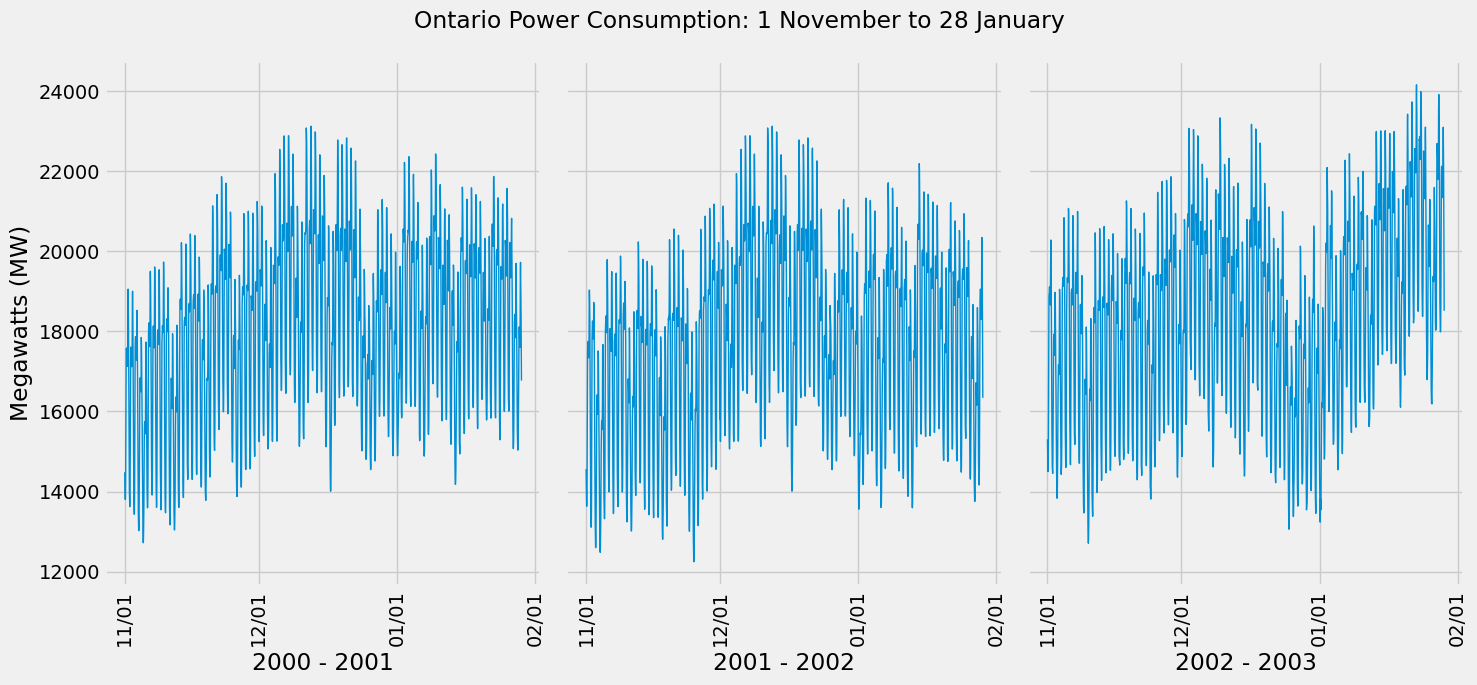

In [114]:
plt.style.use('fivethirtyeight')
myFmt = DateFormatter("%m/%d") 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,7), sharey=True)
ax1.plot(demand_df.loc['2000-11-01':'2001-01-28'], linewidth=1)
ax2.plot(demand_df.loc['2001-11-01':'2002-01-28'], linewidth=1)
ax3.plot(demand_df.loc['2002-11-01':'2003-01-28'], linewidth=1)

ax1.xaxis.set_major_formatter(myFmt) ; ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(myFmt) ; ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(myFmt) ; ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_xlabel('2000 - 2001')
ax2.set_xlabel('2001 - 2002')
ax3.set_xlabel('2002 - 2003')

ax1.set_ylabel('Megawatts (MW)')
plt.suptitle('Ontario Power Consumption: 1 November to 28 January')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

Imputation done 👍

### Dealing with Outlier

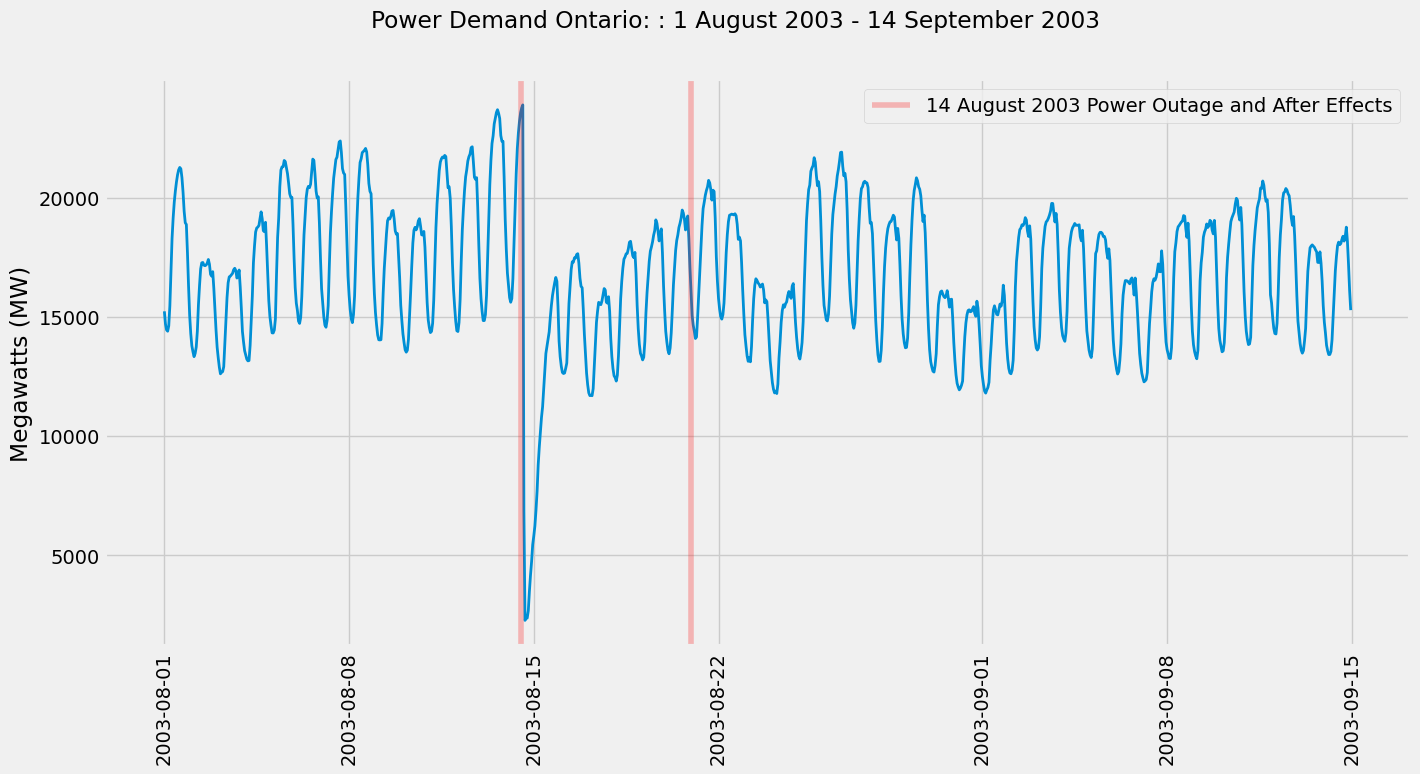

In [115]:
outage_start = datetime.strptime('2003-08-14 12:00:00', '%Y-%m-%d %H:%M:%S')
outage_end = datetime.strptime('2003-08-20 23:00:00', '%Y-%m-%d %H:%M:%S')

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(demand_df.loc['2003-08-01':'2003-09-14'], linewidth=2)
ax.axvline(outage_start, color='r', alpha=0.25, label='14 August 2003 Power Outage and After Effects')
ax.axvline(outage_end, color='r', alpha=0.25)
ax.set_ylabel('Megawatts (MW)')
plt.suptitle('Power Demand Ontario: : 1 August 2003 - 14 September 2003')
plt.xticks(rotation=90)
plt.legend()
plt.show();

Substituting 2003-08-14 to 2003-08-20 demand data from 2003-08-7 to 2003-08-13

In [116]:
start = '2003-08-14 00:00:00' ; end = '2003-08-20 23:00:00'
#index_2001 = pd.DatetimeIndex(freq=freq, start=start, end=end)

imputed_vals = list(demand_df.loc['2003-08-07' : '2003-08-13', 'ont_demand'].values)

demand_df.loc[start : end, 'ont_demand'] = imputed_vals

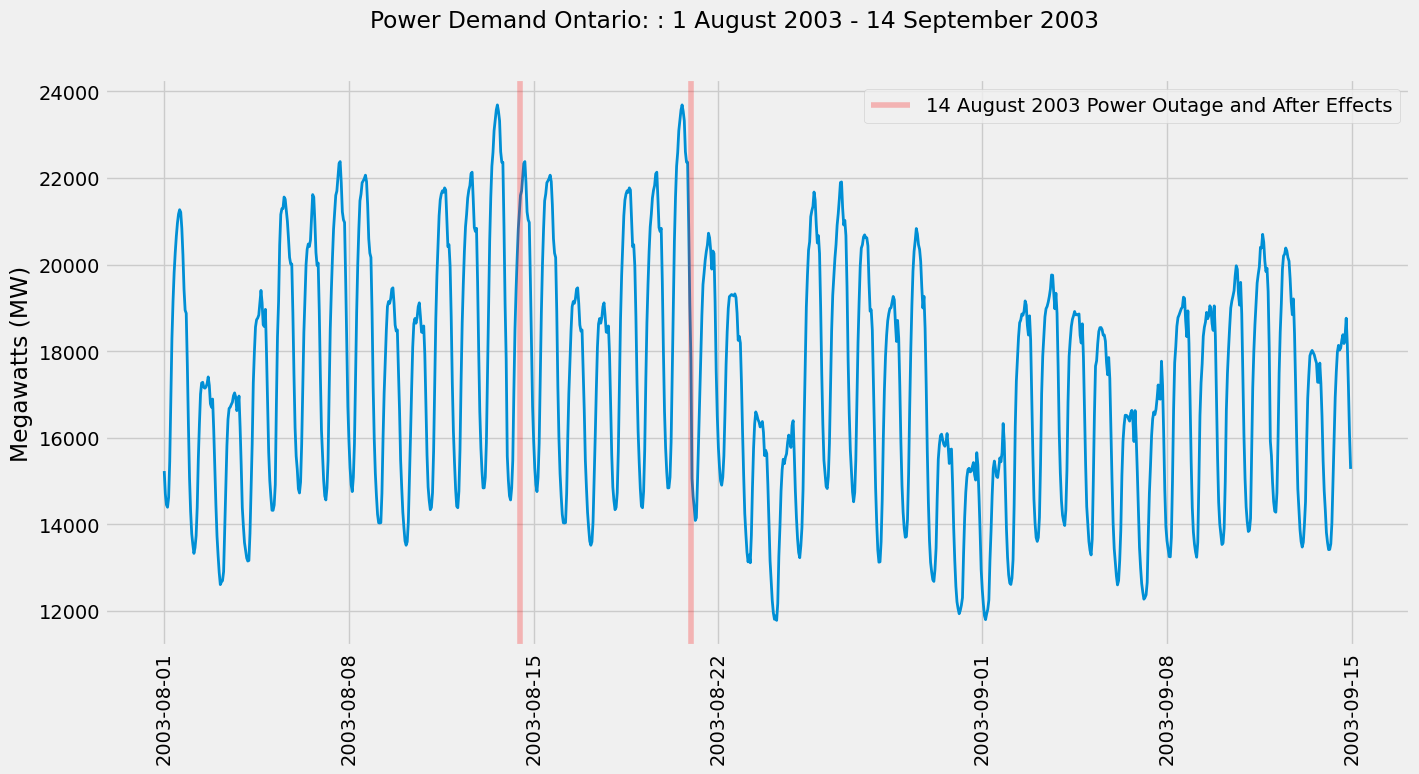

In [117]:
outage_start = datetime.strptime('2003-08-14 12:00:00', '%Y-%m-%d %H:%M:%S')
outage_end = datetime.strptime('2003-08-20 23:00:00', '%Y-%m-%d %H:%M:%S')

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(demand_df.loc['2003-08-01':'2003-09-14'], linewidth=2)
ax.axvline(outage_start, color='r', alpha=0.25, label='14 August 2003 Power Outage and After Effects')
ax.axvline(outage_end, color='r', alpha=0.25)
ax.set_ylabel('Megawatts (MW)')
plt.suptitle('Power Demand Ontario: : 1 August 2003 - 14 September 2003')
plt.xticks(rotation=90)
plt.legend()
plt.show();

Exporting imputed data

In [118]:
demand_df.to_csv(imputed_data_path / "demand.csv")

### Imputed data review

In [119]:
demand_df.head()

,ont_demand
1994-01-01 00:00:00,14422.0
1994-01-01 01:00:00,13845.0
1994-01-01 02:00:00,13372.0
1994-01-01 03:00:00,13025.0
1994-01-01 04:00:00,12869.0


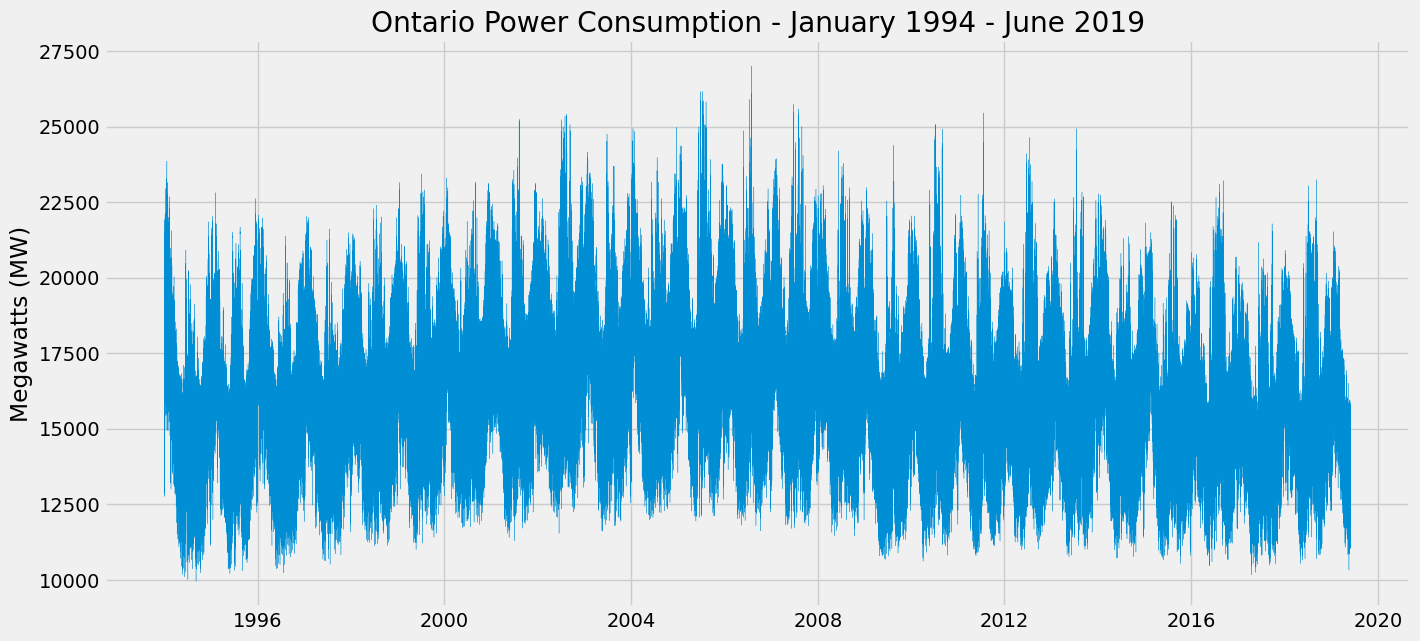

In [120]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(demand_df, linewidth=0.25)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - January 1994 - June 2019')
plt.show();